# Решение задачи прогнозирования открытия вклада

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Задача - по различным характеристикам спрогнозировать целевую переменную - открыл ли клиент вклад на предложенных ему условиях или нет.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [46]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Описание данных клиентов:
* deposit, (yes/no). Открыл ли клиент срочный депозит?
* age, numerical. Количество полных лет.
* job, categorical. Тип занимаемой должности ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown').
* marital, categorical. Cемейное положение ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed).
* education, categorical. Образование ('secondary','tertiary','primary','unknown').
* default, categorical. Имеется ли любой вид кредитования? ('no','yes','unknown').
* housing, categorical. Имеется ли ипотека? ('no','yes','unknown').
* loan, categorical. Имеется ли персональный кредит? ('no','yes','unknown')
* contact, categorical. Вид контакта с клиентом ('cellular','telephone','unknown').
* month, categorical. В каком месяце было сделано предыдущее предложение ('jan', 'feb', 'mar', ..., 'nov', 'dec').
* day, categorical. День месяца в которое было предыдущее предложение (от 1 до 31)
* duration, numerical. Продолжительность предыдущего общения в секундах. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* campaign, numerical. Количество контактов по этой маркетинговой кампании с этим клиентов (includes last contact).
* pdays, numerical. Количество дней, прошедших с предыдущего предложения (число; -1 означает, что раньше не предлагали).
* previous, numerical. Количество контактов с этим клиентом в другие маркетинговые кампании.
* poutcome, categorical. Результат предыдущего предложения ('failure','other','success','unknown').
* balance, numerical. Закодированное название личной числовой характеристики клиента. (Кажется, это просто баланс на счете)




In [3]:
data = pd.read_csv('deposit.csv')
data = data.reindex(sorted(data.columns), axis=1)
data

,age,balance,campaign,contact,day,default,deposit,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,59,2343,1,unknown,5,no,yes,1042,secondary,yes,admin.,no,married,may,-1,unknown,0
1,56,45,1,unknown,5,no,yes,1467,secondary,no,admin.,no,married,may,-1,unknown,0
2,41,1270,1,unknown,5,no,yes,1389,secondary,yes,technician,no,married,may,-1,unknown,0
3,55,2476,1,unknown,5,no,yes,579,secondary,yes,services,no,married,may,-1,unknown,0
4,54,184,2,unknown,5,no,yes,673,tertiary,no,admin.,no,married,may,-1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,1,cellular,20,no,no,257,primary,yes,blue-collar,no,single,apr,-1,unknown,0
11158,39,733,4,unknown,16,no,no,83,secondary,no,services,no,married,jun,-1,unknown,0
11159,32,29,2,cellular,19,no,no,156,secondary,no,technician,no,single,aug,-1,unknown,0
11160,43,0,2,cellular,8,no,no,9,secondary,no,technician,yes,married,may,172,failure,5


In [4]:
data.head()

,age,balance,campaign,contact,day,default,deposit,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,59,2343,1,unknown,5,no,yes,1042,secondary,yes,admin.,no,married,may,-1,unknown,0
1,56,45,1,unknown,5,no,yes,1467,secondary,no,admin.,no,married,may,-1,unknown,0
2,41,1270,1,unknown,5,no,yes,1389,secondary,yes,technician,no,married,may,-1,unknown,0
3,55,2476,1,unknown,5,no,yes,579,secondary,yes,services,no,married,may,-1,unknown,0
4,54,184,2,unknown,5,no,yes,673,tertiary,no,admin.,no,married,may,-1,unknown,0


In [5]:
data.shape

(11162, 17)

In [6]:
data.drop_duplicates()

,age,balance,campaign,contact,day,default,deposit,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,59,2343,1,unknown,5,no,yes,1042,secondary,yes,admin.,no,married,may,-1,unknown,0
1,56,45,1,unknown,5,no,yes,1467,secondary,no,admin.,no,married,may,-1,unknown,0
2,41,1270,1,unknown,5,no,yes,1389,secondary,yes,technician,no,married,may,-1,unknown,0
3,55,2476,1,unknown,5,no,yes,579,secondary,yes,services,no,married,may,-1,unknown,0
4,54,184,2,unknown,5,no,yes,673,tertiary,no,admin.,no,married,may,-1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,1,cellular,20,no,no,257,primary,yes,blue-collar,no,single,apr,-1,unknown,0
11158,39,733,4,unknown,16,no,no,83,secondary,no,services,no,married,jun,-1,unknown,0
11159,32,29,2,cellular,19,no,no,156,secondary,no,technician,no,single,aug,-1,unknown,0
11160,43,0,2,cellular,8,no,no,9,secondary,no,technician,yes,married,may,172,failure,5


In [7]:
data.dtypes

age           int64
balance       int64
campaign      int64
contact      object
day           int64
default      object
deposit      object
duration      int64
education    object
housing      object
job          object
loan         object
marital      object
month        object
pdays         int64
poutcome     object
previous      int64
dtype: object

## Сохранение данных

In [ ]:
data.to_csv("bank_deposits.csv", index=False)

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [8]:
len(data)

11162

Посмотрим, есть ли в данных пропущенные значения.

In [9]:
data.isna().sum()

age          0
balance      0
campaign     0
contact      0
day          0
default      0
deposit      0
duration     0
education    0
housing      0
job          0
loan         0
marital      0
month        0
pdays        0
poutcome     0
previous     0
dtype: int64

## Ошибочные значения

Проверка значений столбцов

In [10]:
data['age'].value_counts()

31    496
32    477
34    466
33    464
35    461
     ... 
92      2
93      2
88      2
95      1
89      1
Name: age, Length: 76, dtype: int64

In [11]:
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [12]:
data['marital'].value_counts()

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

In [13]:
data['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [14]:
data['default'].value_counts()

no     10994
yes      168
Name: default, dtype: int64

In [15]:
data['default'] = data['default'].replace('no', '')
data['default'] = data['default'].replace('yes', '1')

In [16]:
data['default'] = data['default'].astype('bool')

In [17]:
data['default'].value_counts()

False    10994
True       168
Name: default, dtype: int64

In [18]:
data['balance'].value_counts()

 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: balance, Length: 3805, dtype: int64

In [19]:
data['housing'].value_counts()

no     5881
yes    5281
Name: housing, dtype: int64

In [20]:
data['housing'] = data['housing'].replace('no', '')
data['housing'] = data['housing'].replace('yes', '1')

In [21]:
data['housing'] = data['housing'].astype('bool')

In [22]:
data['housing'].value_counts()

False    5881
True     5281
Name: housing, dtype: int64

In [23]:
data['loan'].value_counts()

no     9702
yes    1460
Name: loan, dtype: int64

In [24]:
data['loan'] = data['loan'].replace('no', '')
data['loan'] = data['loan'].replace('yes', '1')

In [25]:
data['loan'] = data['loan'].astype('bool')

In [26]:
data['loan'].value_counts()

False    9702
True     1460
Name: loan, dtype: int64

In [27]:
data['contact'].value_counts()

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

In [28]:
data['day'].value_counts() 

20    570
18    548
30    478
5     477
15    466
14    463
13    453
21    452
6     447
12    445
8     419
17    411
28    410
4     402
29    388
19    384
7     382
11    373
16    369
9     364
2     334
3     306
27    284
22    269
26    252
23    245
25    224
10    163
31    140
24    122
1     122
Name: day, dtype: int64

In [29]:
data['month'].value_counts() 

may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: month, dtype: int64

In [30]:
data['duration'].value_counts() 

97      39
161     38
158     37
119     37
150     37
        ..
915      1
2029     1
1499     1
1399     1
1812     1
Name: duration, Length: 1428, dtype: int64

In [31]:
data['campaign'].value_counts() 

1     4798
2     3028
3     1321
4      771
5      378
6      265
7      139
8      128
9       72
10      52
11      40
13      30
12      29
14      15
17      14
15      13
16       9
18       8
21       8
20       5
19       5
24       5
22       4
30       4
23       3
25       3
26       3
32       2
43       2
29       2
33       1
28       1
41       1
27       1
63       1
31       1
Name: campaign, dtype: int64

In [32]:
data['pdays'].value_counts()

-1      8324
 92      106
 182      89
 91       84
 181      81
        ... 
 437       1
 728       1
 518       1
 828       1
 118       1
Name: pdays, Length: 472, dtype: int64

In [33]:
data['previous'].value_counts()

0     8324
1      887
2      693
3      435
4      244
5      165
6      117
7       77
8       60
9       34
10      30
11      23
12      16
13      11
17      11
14       6
15       5
19       4
16       2
20       2
27       2
23       2
40       1
41       1
28       1
18       1
58       1
55       1
26       1
21       1
22       1
30       1
29       1
37       1
Name: previous, dtype: int64

In [34]:
data['poutcome'].value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [35]:
data['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [36]:
data['deposit'] = data['deposit'].replace('no', '')
data['deposit'] = data['deposit'].replace('yes', '1')

In [37]:
data['deposit'] = data['deposit'].astype('bool')

In [38]:
data['deposit'].value_counts()

False    5873
True     5289
Name: deposit, dtype: int64

In [39]:
data.dtypes

age           int64
balance       int64
campaign      int64
contact      object
day           int64
default        bool
deposit        bool
duration      int64
education    object
housing        bool
job          object
loan           bool
marital      object
month        object
pdays         int64
poutcome     object
previous      int64
dtype: object

## Основные числовые характеристики

In [40]:
data['deposit'].value_counts()

False    5873
True     5289
Name: deposit, dtype: int64

In [41]:
data.describe()

,age,balance,campaign,day,duration,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,2.508421,15.658036,371.993818,51.330407,0.832557
std,11.913369,3225.413326,2.722077,8.420740,347.128386,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,1.000000,2.000000,-1.000000,0.000000
25%,32.000000,122.000000,1.000000,8.000000,138.000000,-1.000000,0.000000
50%,39.000000,550.000000,2.000000,15.000000,255.000000,-1.000000,0.000000
75%,49.000000,1708.000000,3.000000,22.000000,496.000000,20.750000,1.000000
max,95.000000,81204.000000,63.000000,31.000000,3881.000000,854.000000,58.000000


In [42]:
data.describe(include='object') # категориальные колонки

,contact,education,job,marital,month,poutcome
count,11162,11162,11162,11162,11162,11162
unique,3,4,12,3,12,4
top,cellular,secondary,management,married,may,unknown
freq,8042,5476,2566,6351,2824,8326


In [43]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,balance,campaign,day,default,deposit,duration,housing,loan,pdays,previous
age,1.000000,0.112300,-0.005278,-0.000762,-0.011425,0.034901,0.000189,-0.168700,-0.031418,0.002774,0.020169
balance,0.112300,1.000000,-0.013894,0.010467,-0.060954,0.081129,0.022436,-0.077092,-0.084589,0.017411,0.030805
campaign,-0.005278,-0.013894,1.000000,0.137007,0.030975,-0.128081,-0.041557,0.006660,0.034722,-0.102726,-0.049699
day,-0.000762,0.010467,0.137007,1.000000,0.017342,-0.056326,-0.018511,-0.014770,0.017269,-0.077232,-0.058981
default,-0.011425,-0.060954,0.030975,0.017342,1.000000,-0.040680,-0.009760,0.011076,0.076434,-0.036282,-0.035273
deposit,0.034901,0.081129,-0.128081,-0.056326,-0.040680,1.000000,0.451919,-0.203888,-0.110580,0.151593,0.139867
duration,0.000189,0.022436,-0.041557,-0.018511,-0.009760,0.451919,1.000000,0.035051,-0.001914,-0.027392,-0.026716
housing,-0.168700,-0.077092,0.006660,-0.014770,0.011076,-0.203888,0.035051,1.000000,0.076761,0.064497,-0.000840
loan,-0.031418,-0.084589,0.034722,0.017269,0.076434,-0.110580,-0.001914,0.076761,1.000000,-0.030416,-0.022668
pdays,0.002774,0.017411,-0.102726,-0.077232,-0.036282,0.151593,-0.027392,0.064497,-0.030416,1.000000,0.507272


## Визуализация данных

Text(0, 0.5, 'deposit Y/N')

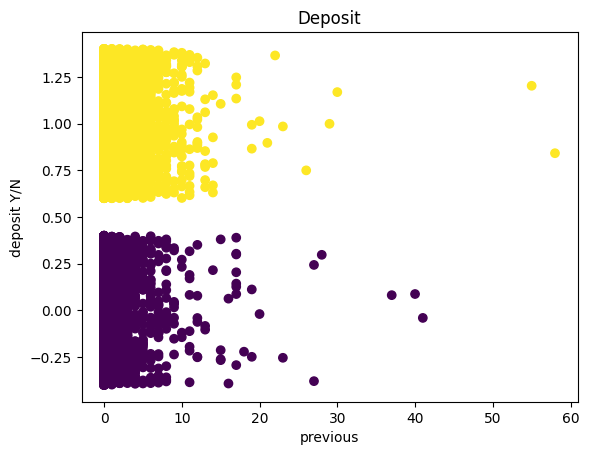

In [45]:
plt.scatter(data['previous'], data['deposit'] + np.random.uniform(-0.4, 0.4, len(data['deposit'])), c=data['deposit'])
plt.title('Deposit')
plt.xlabel('previous')
plt.ylabel('deposit Y/N')

In [553]:
data.groupby('deposit')['previous'].mean()

deposit
False    0.528350
True     1.170354
Name: previous, dtype: float64

Text(0, 0.5, 'deposit Y/N')

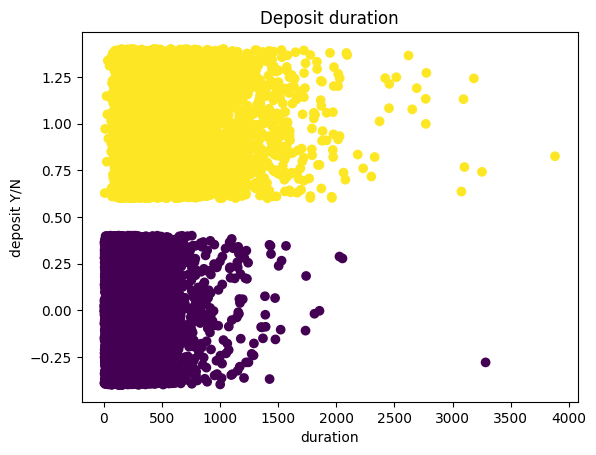

In [47]:
plt.scatter(data['duration'], data['deposit']+ np.random.uniform(-0.4, 0.4, len(data['deposit'])), c=data['deposit'])
plt.title('Deposit duration')
plt.xlabel('duration')
plt.ylabel('deposit Y/N')

In [48]:
data.groupby('deposit')['duration'].mean()

deposit
False    223.130257
True     537.294574
Name: duration, dtype: float64

## <font color='green'>2.1. Обучение модели</font>



Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [49]:
X = data.drop('deposit', axis=1)
y = data['deposit']

Когда мы решаем задачу классификации, мы можем захотеть предсказывать не только классы, но и их вероятности. Для целей бизнеса, например, полезно знать, с какой вероятностью клиент вернет кредит (а не просто - вернет кредит или не вернет). Например, если клиент уйдет из банка с вероятностью 0.95, то это очень ненадежный клиент. А если с вероятностью 0.52  - этот клиент под вопросом. Но с точки зрения бинарной классификации для обоих клиентов модель предскажет, что они уйдут, так как стандартный порог перевода вероятности в классы - 0.5. 

* задача классификации, в которой модель предсказывает только классы - это **жесткая классификация**
* если же классификатор предсказывает вероятности классов - это **мягкая классификация**

Давайте применим логистическую регрессию для определения возьмет ли клиент депозит или нет!

Сначала выкинем нечисловые столбцы.

In [50]:
X = X.drop(['job','marital','education','default','housing','loan','contact','month','poutcome'], axis=1)

Мы разбиваем данные на train и test, чтобы:
* на тренировочных данных обучить модель
* на тестовых применить обученную модель и затем проверить качество модели

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
X.head()


,age,balance,campaign,day,duration,pdays,previous
0,59,2343,1,5,1042,-1,0
1,56,45,1,5,1467,-1,0
2,41,1270,1,5,1389,-1,0
3,55,2476,1,5,579,-1,0
4,54,184,2,5,673,-1,0


Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,age,balance,campaign,day,duration,pdays,previous
0,1.581951,2.083507,1.662174,0.284318,-0.785527,-0.474357,-0.365571
1,0.823300,-0.500178,-0.183877,-0.545702,-0.258692,1.979568,2.348973
2,-1.115476,-0.812078,-0.183877,-1.138573,0.982105,-0.474357,-0.365571
3,-0.946887,0.925652,0.554543,0.640040,0.561789,-0.474357,-0.365571
4,-0.862592,0.321128,-0.553088,-0.071405,-0.342179,1.225928,0.991701


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [55]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [56]:
pred_test = model.predict(Xtest) # предсказание классов

Посмотрим на предсказания модели и оценим ее качество.

In [57]:
pred_test[:5]

array([False,  True,  True,  True, False])

In [58]:
accuracy_score(ytest, pred_test)

0.7384450017914725

Проверим, сбалансирована ли выборка.

In [59]:
y.value_counts()

False    5873
True     5289
Name: deposit, dtype: int64

In [60]:
pred_test[:20]

array([False,  True,  True,  True, False,  True, False, False, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False])

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Давайте посмотрим, какие метрики полезно считать в задаче классификации, кроме accuracy.

<font color='blue'>Для оценки качества моделей бинарной классификации полезно смотреть на **матрицу ошибок** (confusion matrix):</font>

In [61]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[1178,  272],
       [ 458,  883]], dtype=int64)

In [62]:
ytest.value_counts()

False    1450
True     1341
Name: deposit, dtype: int64

<font color='blue'>Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю клиентов c депозитами (объектов положительного класса) нашла модель.</font>

In [63]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.6584638329604773

In [64]:
from sklearn.metrics import precision_score

precision_score(ytest, pred_test)

0.7645021645021645

In [65]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.67830071, 0.32169929],
       [0.03537984, 0.96462016],
       [0.21309925, 0.78690075],
       [0.10379471, 0.89620529],
       [0.83351689, 0.16648311],
       [0.48136114, 0.51863886],
       [0.50257942, 0.49742058],
       [0.62936942, 0.37063058],
       [0.56027527, 0.43972473],
       [0.26056253, 0.73943747]])

<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 на порог поменьше.</blue>

In [67]:
probs_deposit = probs[:,1]

classes = probs_deposit > 0.4

In [68]:
confusion_matrix(ytest, classes)

array([[1022,  428],
       [ 311, 1030]], dtype=int64)

In [69]:
ytest.value_counts()

False    1450
True     1341
Name: deposit, dtype: int64

In [70]:
recall_score(ytest, classes)

0.7680835197613721

In [71]:
precision_score(ytest, classes)

0.7064471879286695

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [72]:
model.coef_, model.intercept_

(array([[ 0.05867868,  0.15434186, -0.35814047, -0.04339455,  1.60024343,
          0.22916524,  0.32045889]]),
 array([0.01797106]))

In [73]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
2,campaign,-0.358140
3,day,-0.043395
0,age,0.058679
1,balance,0.154342
5,pdays,0.229165
6,previous,0.320459
4,duration,1.600243


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [75]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.3

confusion_matrix(ytest, classes2)

array([[ 912,  538],
       [ 188, 1153]], dtype=int64)

In [76]:
recall_score(ytest, classes2)

0.8598061148396718

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [ ]:
Xtest['predictions'] = probs_deposit

Xtest.to_csv("PredictionsDeposit.csv", index=False)

Теперь сохраним саму модель:

In [ ]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [77]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.7064471879286695
recall:  0.7680835197613721
auc-roc:  0.820057599835429


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [78]:
from catboost import CatBoostClassifier, Pool

In [79]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [80]:
gbm = CatBoostClassifier(iterations=500, #сколько деревьев
                          depth=2, #глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

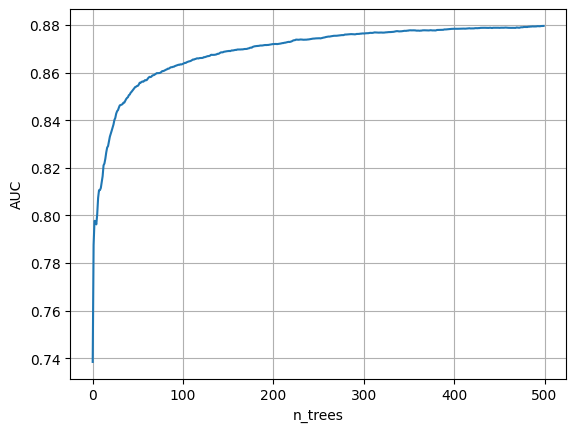

In [81]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [82]:
gbm_classes = (gbm_preds[:, 1] > 0.35)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.7360594795539034
recall:  0.8859060402684564
auc-roc:  0.8796610866826096


In [83]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
2,campaign,3.315079
6,previous,6.295920
1,balance,6.518516
3,day,7.566874
0,age,8.869004
5,pdays,14.847322
4,duration,52.587284


## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['job','marital','education','default','housing','loan','contact','month','poutcome'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [84]:
X_full = data.drop('deposit', axis=1)

In [85]:
X_full.dtypes

age           int64
balance       int64
campaign      int64
contact      object
day           int64
default        bool
duration      int64
education    object
housing        bool
job          object
loan           bool
marital      object
month        object
pdays         int64
poutcome     object
previous      int64
dtype: object

In [86]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [87]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['job','marital','education','contact','month','poutcome']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [88]:
X_transformed.shape

(8371, 45)

In [89]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [90]:
classes = (pred[:, 1] > 0.45)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

precision:  0.8103448275862069
recall:  0.8061148396718867
auc-roc:  0.8987076036925609


In [91]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=800,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.7759259259259259
recall:  0.9373601789709173
auc-roc:  0.9211874823214792


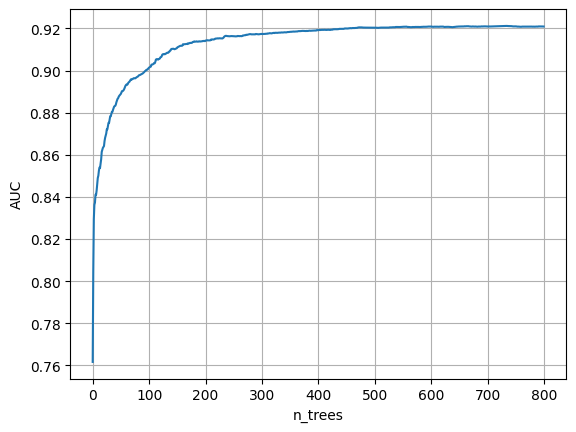

In [92]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()
